In [1]:
import keras
import tensorflow as tf

import os
tf.config.optimizer.set_jit(False)  # Desativa XLA

2024-09-12 16:31:22.890014: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 16:31:22.903839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 16:31:22.908114: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 16:31:22.918252: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-12 16:31:23.816037: W tensorflow/compiler/tf2

In [2]:
from segmentandoDatasets import *

segmentando_datasets(10000,10000,10000)

DataFrame do local PUC salvo como: Datasets_csv/df_PUC.csv
DataFrame do local PUC:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
1  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
2  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied
3  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...     Empty
4  /home/lucas/Downloads/PKLot/PKLotSegmented/PUC...  Occupied


DataFrame do local UFPR04 salvo como: Datasets_csv/df_UFPR04.csv
DataFrame do local UFPR04:
                                      caminho_imagem    classe
0  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...  Occupied
1  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...  Occupied
2  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...  Occupied
3  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty
4  /home/lucas/Downloads/PKLot/PKLotSegmented/UFP...     Empty


DataFrame do local UFPR05 salvo como: Datasets_csv/df_UFPR05.csv


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from typing import List, Tuple
import os

def preprocessamento(caminho: str, proporcao_treino: float = 0.6, proporcao_teste: float = 0.2, proporcao_validacao: float = 0.2, autoencoder: bool = False):
    """
    Ao passar um dataFrame .csv, ele irá retornar geradores de dados para treino, teste e validação + os 3 .csv dividos igualmente os geradores.
    
    Parâmetros:
        caminho (str): Caminho para o arquivo CSV.
        proporcao_treino (float): Proporção de dados de treino.
        proporcao_teste (float): Proporção de dados de teste.
        proporcao_validacao (float): Proporção de dados de validação.
        autoencoder (bool): Se True, prepara os dados para um autoencoder (class_mode='input').
                            Se False, prepara os dados para classificação binária (class_mode='binary').
    
    Retorna:
        treino_gerador, validacao_gerador, teste_gerador, treino, teste, validacao
    """
    dataframe = pd.read_csv(caminho)

    treino, teste = train_test_split(dataframe, test_size=proporcao_teste, random_state=42)
    treino, validacao = train_test_split(treino, test_size=proporcao_validacao / (1 - proporcao_teste), random_state=42)

    img_width, img_height = 64, 64
    batch_size = 32

    def normalize_image(img):
        return img / 255.0

    treino_datagen = ImageDataGenerator(preprocessing_function=normalize_image)
    validacao_datagen = ImageDataGenerator(preprocessing_function=normalize_image)
    teste_datagen = ImageDataGenerator(preprocessing_function=normalize_image)

    class_mode = 'input' if autoencoder else 'binary'

    treino_gerador = treino_datagen.flow_from_dataframe(
        dataframe=treino,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe', #Usar a imagem como saída se for autoencoder
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode,  #Class mode baseado no parâmetro autoencoder
        shuffle=False
    )

    validacao_gerador = validacao_datagen.flow_from_dataframe(
        dataframe=validacao,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=False
    )

    teste_gerador = teste_datagen.flow_from_dataframe(
        dataframe=teste,
        x_col='caminho_imagem',
        y_col='caminho_imagem' if autoencoder else 'classe',  
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=class_mode, 
        shuffle=False
    )

    return treino_gerador, validacao_gerador, teste_gerador, treino, teste, validacao

In [4]:
csv_file = 'Datasets_csv/df_PUC.csv'
treino_gerador, validacao_gerador, teste_gerador, treino, teste, validacao = preprocessamento(csv_file, autoencoder=True)

Found 6000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


In [5]:
from keras.layers import Input, Flatten, Dense, Reshape
from keras.models import Sequential

encoder = keras.models.Sequential([
    keras.layers.Reshape([64,64,3], input_shape=[64,64,3]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),  
])

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1726169497.651494   41998 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726169498.339422   41998 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726169498.339764   41998 cuda_executor.cc:1015] successful NUMA node rea

In [6]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu", input_shape=[4, 4, 128]),
    keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
    keras.layers.Conv2DTranspose(3, kernel_size=(3, 3), padding="same", activation="sigmoid"),
])

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="binary_crossentropy", optimizer='adam')

In [8]:
history = autoencoder.fit(treino_gerador, epochs=10, batch_size=16, validation_data=(validacao_gerador))

Epoch 1/10


/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726169502.802385   42105 service.cc:146] XLA service 0xb2d06f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726169502.802435   42105 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2024-09-12 16:31:42.886418: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-12 16:31:43.225853: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  6/188 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.6928

I0000 00:00:1726169506.606998   42105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 120ms/step - loss: 0.6621 - val_loss: 0.6171
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6116 - val_loss: 0.6060
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6015 - val_loss: 0.5981
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5964 - val_loss: 0.5889
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5861 - val_loss: 0.5853
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5836 - val_loss: 0.5839
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5819 - val_loss: 0.5840
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5824 - val_loss: 0.5838
Epoch 9/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5791 - val_loss: 0.5825
Epoch 10/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5780 - val_loss: 0.5812


<Axes: >

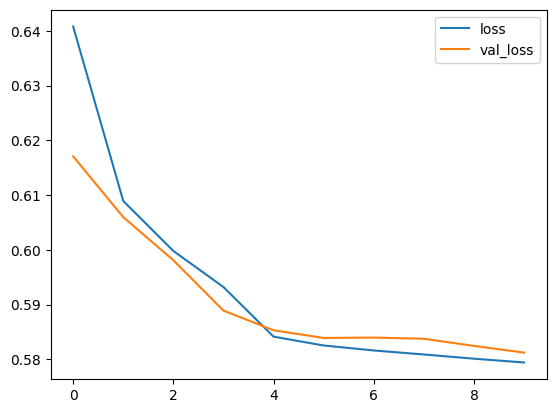

In [9]:
pd.DataFrame(history.history).plot()

In [10]:
autoencoder.save("Modelos_keras/Autoencoder.keras")
autoencoder.save_weights("weights_finais/Autoencoder.weights.h5")

In [11]:
autoencoder.load_weights("weights_finais/Autoencoder.weights.h5")

In [12]:
# Verificar forma antes e depois da previsão
imagens_codificadas = encoder.predict(teste_gerador)
print(f'Forma de encoded_imgs: {imagens_codificadas.shape}')

imagens_decodificadas = decoder.predict(imagens_codificadas)

 1/63 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step

/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step
Forma de encoded_imgs: (2000, 4, 4, 128)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_autoencoder(x_test, Autoencoder):
    def normalize(image):
        image = np.clip(image, 0, 1)  # Garante que a imagem esteja no intervalo [0, 1]
        return (image - image.min()) / (image.max() - image.min()) if image.max() != image.min() else image

    plt.figure(figsize=(16, 8))

    for i in range(8):
        # Imagem original
        plt.subplot(2, 8, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis("off")

        # Predição e normalização
        pred = Autoencoder.predict(x_test[i].reshape((1, 64, 64, 3)))
        pred_img = normalize(pred[0])

        plt.subplot(2, 8, i + 8 + 1)
        plt.imshow(pred_img)
        plt.title("Reconstruída")
        plt.axis("off")

    plt.show()


In [14]:
"""_, _, _, x_train_UFPR04, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR04.csv", 0.6, 0.2, 0.2)
_, _, _, x_train_UFPR05, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR05.csv", 0.6, 0.2, 0.2)"""

'_, _, _, x_train_UFPR04, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR04.csv", 0.6, 0.2, 0.2)\n_, _, _, x_train_UFPR05, y_train, x_test, y_test, x_val, y_val = preprocessamento("Datasets_csv/df_UFPR05.csv", 0.6, 0.2, 0.2)'

In [15]:
x_teste, _ = next(teste_gerador)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


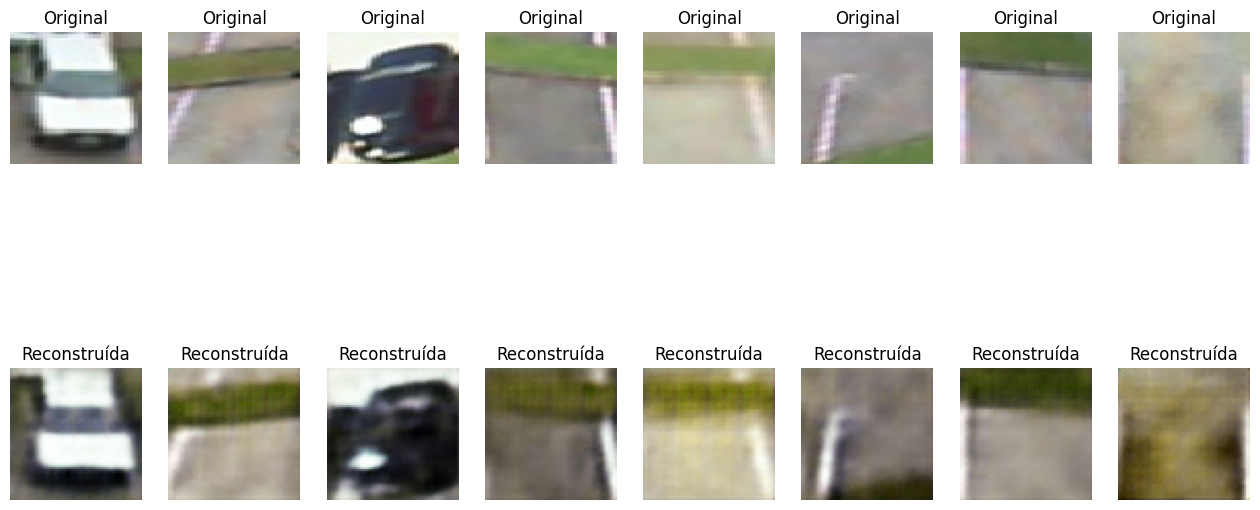

'plot_autoencoder(x_train_UFPR04, autoencoder)\nplot_autoencoder(x_train_UFPR05, autoencoder)'

In [16]:
plot_autoencoder(x_teste, autoencoder)
"""plot_autoencoder(x_train_UFPR04, autoencoder)
plot_autoencoder(x_train_UFPR05, autoencoder)"""

In [17]:
y_teste = teste['classe']
class_mapping = {'Empty': 0, 'Occupied': 1}

y_teste_numerico = y_teste.map(class_mapping)

print("print y:", y_teste_numerico)
print("shape de y_teste:", y_teste_numerico.shape)

print y: 6252    1
4684    0
1731    1
4742    0
4521    0
       ..
6412    0
8285    0
7853    1
1095    0
6929    0
Name: classe, Length: 2000, dtype: int64
shape de y_teste: (2000,)


In [18]:
shape_imagem_codificada = imagens_codificadas.reshape((imagens_codificadas.shape[0], -1))

In [19]:
classificador = Sequential([
    Dense(128, activation='relu', input_shape=(2048,)),  # Ajuste a entrada conforme o tamanho do vetor
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Saída para classificação binária
])


/home/lucas/PIBIC (copy)/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
classificador.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [21]:
classificador.fit(shape_imagem_codificada, y_teste_numerico, epochs=10, batch_size=8, validation_split=0.1)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9418 - loss: 0.1364 - val_accuracy: 0.9950 - val_loss: 0.0212
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.9956 - loss: 0.0140 - val_accuracy: 0.9950 - val_loss: 0.0073
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.9960 - loss: 0.0113 - val_accuracy: 0.9700 - val_loss: 0.0849
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.9942 - loss: 0.0162 - val_accuracy: 0.9950 - val_loss: 0.0064
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 4.2404e-04
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 1.0000 - loss: 3.5411e-04 - val_accuracy: 1.0000 - val_loss: 6.1104e-04
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 1.0000 - loss:

In [22]:
classificador.save("Modelos_keras/classificador.h5")
classificador.save_weights("weights_finais/classificador.weights.h5")

In [39]:
def preprocessamento_completo(caminho: str):
    """
    Prepara e retorna geradores de dados e dados em formato de arrays numpy para o conjunto inteiro.
    """

    nome_arquivo = os.path.basename(caminho)

    # Removendo a extensão e pegando a parte desejada
    nome_parte = os.path.splitext(nome_arquivo)[0].split('_')[1]

    dataframe = pd.read_csv(caminho)
    
    dataframe['classe'] = dataframe['classe'].astype(str)

    img_width, img_height = 256, 256
    batch_size = 32

    def normalize_image(img):
        return img / 255.0

    datagen = ImageDataGenerator(preprocessing_function=normalize_image)

    gerador = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col='caminho_imagem',
        y_col='classe',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False  # Não embaralhar para garantir a ordem dos dados
    )

    def extrair_dados(gerador):
        x = []
        y = []
        for img_batch, label_batch in gerador:
            x.append(img_batch)
            y.append(label_batch)
            if len(x) * gerador.batch_size >= gerador.samples:
                break
        return np.concatenate(x), np.concatenate(y)

    x_dados, y_dados = extrair_dados(gerador)

    return nome_parte, x_dados, y_dados

def plot_predictions(images, predictions, true_labels, save_path:str, class_names, num=5):
        plt.figure(figsize=(10, 10))
        for i in range(num):
            plt.subplot(1, num, i + 1)
            plt.imshow(images[i])
            
            # Garantir que predictions e true_labels são inteiros
            pred_class = int(predictions[i])
            true_class = class_names.index(true_labels[i])
            
            plt.title(f'Pred: {class_names[pred_class]}\nTrue: {class_names[true_class]}')
            plt.axis('off')
        plt.savefig(save_path)
        plt.show()

In [40]:
def carregar_e_preprocessar_imagens(caminho_imagens, tamanho=(64, 64)):
    imagens = []
    for caminho in caminho_imagens:
        img = load_img(caminho, target_size=tamanho)
        img_array = img_to_array(img) / 255.0
        imagens.append(img_array)
    return np.array(imagens)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step


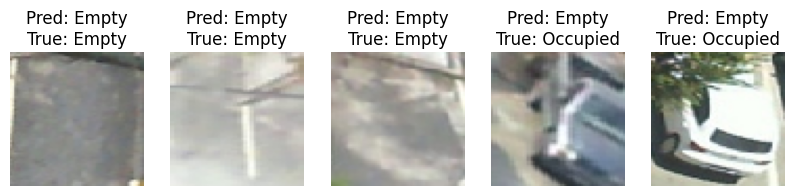

TypeError: Labels in y_true and y_pred should be of the same type. Got y_true=['Empty' 'Occupied'] and y_pred=[0]. Make sure that the predictions provided by the classifier coincides with the true labels.

In [43]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from visualizacao import plot_confusion_matrix

def carregar_e_preprocessar_imagens(caminho_imagens, tamanho=(64, 64)):
    imagens = []
    for caminho in caminho_imagens:
        img = load_img(caminho, target_size=tamanho)
        img_array = img_to_array(img) / 255.0  # Normalizar para intervalo [0,1]
        imagens.append(img_array)
    return np.array(imagens)

def predizer_classes(classificador, encoder, caminho:str):
    nome_arquivo = os.path.basename(caminho)
    nome = os.path.splitext(nome_arquivo)[0].split('_')[1]

    dataframe = pd.read_csv(caminho)
    dataframe['classe'] = dataframe['classe'].astype(str)
    y_dados = dataframe['classe']
    x_dados = dataframe['caminho_imagem']

    imagens = carregar_e_preprocessar_imagens(x_dados)
    
    imagem_codificada = encoder.predict(imagens)
    flatten_imgs = imagem_codificada.reshape((imagem_codificada.shape[0], -1))

    predicao = classificador.predict(flatten_imgs)
    predicao_classes = predicao.argmax(axis=1)

    # Passar as imagens reais para plotar as previsões
    plot_predictions(imagens[:10], predicao_classes[:10], y_dados[:10], f"Resultados/Predicoes/Autoencoder_{nome}", class_names=['Empty', 'Occupied'])
    plot_confusion_matrix(y_dados, predicao_classes, ['Empty', 'Occupied'], f"Resultados/Matriz_de_confusao/Autoencoder/Autoencoder_{nome}", f"Autoencoder {nome}")

predizer_classes(classificador, encoder, 'Datasets_csv/df_UFPR04.csv')
predizer_classes(classificador, encoder, 'Datasets_csv/df_UFPR05.csv')
predizer_classes(classificador, encoder, 'Datasets_csv/df_PUC.csv')
